In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# === Paramètres ===
BATCH_SIZE = 128
NOISE_DIM = 64
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LR = 2e-4
SAVE_INTERVAL = 10



# === Dossiers ===
base_model_dir = "/content/drive/MyDrive/park_right"  # Poids préentraînés
fine_tune_model_dir = "/content/drive/MyDrive/park_right/saved_models_park_right"
sample_dir = "/content/drive/MyDrive/park_right/generated_samples_park_right"
data_path = "/content/drive/MyDrive/park_right/park_all_right.npz"

os.makedirs(fine_tune_model_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# === Construction du générateur et du critic ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

def build_critic():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(1200, 1)),

        tf.keras.layers.Conv1D(64, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(128, 15, strides=4, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Conv1D(256, 15, strides=3, padding='same'),
        tf.keras.layers.LeakyReLU(0.2),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1)
    ])
    return model

# === Initialisation ===
generator = build_generator()
critic = build_critic()

generator_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)
critic_optimizer = tf.keras.optimizers.Adam(LR, beta_1=0.5)

# === Charger les poids préentraînés sur "controls" ===
generator.load_weights(f"{base_model_dir}/generator_epoch_250.weights.h5")
critic.load_weights(f"{base_model_dir}/critic_epoch_250.weights.h5")
print("✓ Poids préentraînés chargés depuis les sujets parkinson")

# === Chargement des données controls left ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices(data)
dataset = dataset.shuffle(1000).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

# === Gradient Penalty ===
def gradient_penalty(real, fake):
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1, 1], 0., 1.)
    interpolated = real + alpha * (fake - real)

    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = critic(interpolated, training=True)

    grads = tape.gradient(pred, [interpolated])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
    return tf.reduce_mean((slopes - 1.)**2)

# === Entraînement ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
history = {'critic': [], 'gen': []}

def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # Critic
    for _ in range(CRITIC_STEPS):
        with tf.GradientTape() as tape:
            fake = generator(noise, training=True)
            real_out = critic(batch, training=True)
            fake_out = critic(fake, training=True)

            gp = gradient_penalty(batch, fake)
            c_loss = tf.reduce_mean(fake_out) - tf.reduce_mean(real_out) + GP_WEIGHT * gp

        grads = tape.gradient(c_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads, critic.trainable_variables))

    # Generator
    with tf.GradientTape() as tape:
        fake = generator(noise, training=True)
        g_loss = -tf.reduce_mean(critic(fake, training=True))

    grads = tape.gradient(g_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    return c_loss, g_loss

# === Boucle d'entraînement ===
for epoch in range(EPOCHS):
    epoch_c_loss = []
    epoch_g_loss = []

    for batch in tqdm(dataset, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        c_loss, g_loss = train_step(batch)
        epoch_c_loss.append(c_loss)
        epoch_g_loss.append(g_loss)

    avg_c_loss = tf.reduce_mean(epoch_c_loss)
    avg_g_loss = tf.reduce_mean(epoch_g_loss)

    history['critic'].append(avg_c_loss.numpy())
    history['gen'].append(avg_g_loss.numpy())

    print(f"\nEpoch {epoch+1} | Critic: {avg_c_loss:.4f} | Generator: {avg_g_loss:.4f}")

    # Sauvegarde périodique
    if (epoch + 1) % SAVE_INTERVAL == 0:
        generator.save_weights(f'{fine_tune_model_dir}/generator_epoch_{epoch+1}.weights.h5')
        critic.save_weights(f'{fine_tune_model_dir}/critic_epoch_{epoch+1}.weights.h5')

        samples = generator(fixed_noise)
        plt.figure(figsize=(15, 3))
        for i in range(5):
            plt.subplot(5, 1, i+1)
            plt.plot(samples[i, :, 0])
            plt.ylim(-1, 1)
        plt.tight_layout()
        plt.savefig(f'{sample_dir}/epoch_{epoch+1}.png')
        plt.close()

print("✓ Fine-tuning terminé pour parkinson pied droite")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


✓ Poids préentraînés chargés depuis les sujets parkinson


Epoch 1/200: 100%|██████████| 15/15 [00:15<00:00,  1.04s/it]



Epoch 1 | Critic: -1.2546 | Generator: 1.2895


Epoch 2/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 2 | Critic: -2.0711 | Generator: 14.0336


Epoch 3/200: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]



Epoch 3 | Critic: -3.0371 | Generator: 12.8169


Epoch 4/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 4 | Critic: -2.3970 | Generator: 10.9797


Epoch 5/200: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 5 | Critic: -1.6586 | Generator: 10.7852


Epoch 6/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 6 | Critic: -1.4951 | Generator: 10.1333


Epoch 7/200: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 7 | Critic: -1.0956 | Generator: 6.8178


Epoch 8/200: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 8 | Critic: -1.1174 | Generator: -1.3745


Epoch 9/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 9 | Critic: -1.2555 | Generator: -17.0222


Epoch 10/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 10 | Critic: -0.7574 | Generator: -10.6803


Epoch 11/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 11 | Critic: -1.1550 | Generator: -17.0799


Epoch 12/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 12 | Critic: -1.1445 | Generator: -4.0360


Epoch 13/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 13 | Critic: -0.9068 | Generator: -16.8351


Epoch 14/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 14 | Critic: -1.1136 | Generator: -38.5307


Epoch 15/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 15 | Critic: -0.7069 | Generator: 10.7540


Epoch 16/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 16 | Critic: -1.0523 | Generator: 2.8812


Epoch 17/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 17 | Critic: -0.2038 | Generator: -16.9202


Epoch 18/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 18 | Critic: -0.5841 | Generator: -7.6844


Epoch 19/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 19 | Critic: -0.8117 | Generator: 10.0426


Epoch 20/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 20 | Critic: -0.8858 | Generator: 14.9832


Epoch 21/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 21 | Critic: -0.7188 | Generator: -1.1474


Epoch 22/200: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 22 | Critic: -0.8634 | Generator: -2.3172


Epoch 23/200: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 23 | Critic: -0.7346 | Generator: 1.6712


Epoch 24/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 24 | Critic: -1.2584 | Generator: 4.9396


Epoch 25/200: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]



Epoch 25 | Critic: -1.3803 | Generator: 16.7287


Epoch 26/200: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 26 | Critic: -0.9672 | Generator: 26.8128


Epoch 27/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 27 | Critic: -0.8882 | Generator: 17.6957


Epoch 28/200: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 28 | Critic: -1.3696 | Generator: -15.4854


Epoch 29/200: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 29 | Critic: -0.9709 | Generator: -18.4135


Epoch 30/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 30 | Critic: -0.3900 | Generator: -1.5288


Epoch 31/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 31 | Critic: -0.8337 | Generator: 8.7401


Epoch 32/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 32 | Critic: -0.7968 | Generator: 17.8256


Epoch 33/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 33 | Critic: -0.5996 | Generator: 8.1864


Epoch 34/200: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]



Epoch 34 | Critic: -1.0397 | Generator: 10.3340


Epoch 35/200: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 35 | Critic: -0.9886 | Generator: 2.1728


Epoch 36/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 36 | Critic: -0.9321 | Generator: 18.6622


Epoch 37/200: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 37 | Critic: -1.1751 | Generator: 1.2940


Epoch 38/200: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 38 | Critic: -0.9472 | Generator: -8.7117


Epoch 39/200: 100%|██████████| 15/15 [00:10<00:00,  1.37it/s]



Epoch 39 | Critic: -0.5273 | Generator: -13.1068


Epoch 40/200: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 40 | Critic: -0.9220 | Generator: -6.7316


Epoch 41/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 41 | Critic: -1.0255 | Generator: 6.3918


Epoch 42/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 42 | Critic: -1.0346 | Generator: 4.5915


Epoch 43/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 43 | Critic: -0.7423 | Generator: -10.5443


Epoch 44/200: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 44 | Critic: -0.4284 | Generator: -6.2892


Epoch 45/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 45 | Critic: -0.6534 | Generator: -5.3913


Epoch 46/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 46 | Critic: -0.7807 | Generator: -6.6090


Epoch 47/200: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 47 | Critic: -1.0021 | Generator: -4.8853


Epoch 48/200: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]



Epoch 48 | Critic: -0.8717 | Generator: 9.5560


Epoch 49/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 49 | Critic: -1.1565 | Generator: 9.8834


Epoch 50/200: 100%|██████████| 15/15 [00:10<00:00,  1.41it/s]



Epoch 50 | Critic: -1.2194 | Generator: 4.5085


Epoch 51/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 51 | Critic: -1.1731 | Generator: -0.7659


Epoch 52/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 52 | Critic: -0.4506 | Generator: 16.0185


Epoch 53/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 53 | Critic: -1.0682 | Generator: 19.6685


Epoch 54/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 54 | Critic: -0.7517 | Generator: 3.4576


Epoch 55/200: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]



Epoch 55 | Critic: -0.4559 | Generator: 4.9663


Epoch 56/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 56 | Critic: -0.3832 | Generator: 0.0164


Epoch 57/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 57 | Critic: -0.7566 | Generator: -2.8651


Epoch 58/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 58 | Critic: -0.9425 | Generator: -14.5299


Epoch 59/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 59 | Critic: -1.0749 | Generator: -6.8110


Epoch 60/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 60 | Critic: -0.7382 | Generator: 2.7213


Epoch 61/200: 100%|██████████| 15/15 [00:10<00:00,  1.39it/s]



Epoch 61 | Critic: -1.1018 | Generator: 12.3872


Epoch 62/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 62 | Critic: -0.6702 | Generator: 8.3065


Epoch 63/200: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]



Epoch 63 | Critic: -0.6470 | Generator: 2.8205


Epoch 64/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 64 | Critic: -0.6171 | Generator: 2.5706


Epoch 65/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 65 | Critic: -1.0850 | Generator: 1.4463


Epoch 66/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 66 | Critic: -0.8788 | Generator: 9.7022


Epoch 67/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 67 | Critic: -0.7049 | Generator: 7.5123


Epoch 68/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 68 | Critic: -1.1495 | Generator: 7.4714


Epoch 69/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 69 | Critic: -0.8538 | Generator: 6.5710


Epoch 70/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 70 | Critic: -1.0081 | Generator: -2.9497


Epoch 71/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 71 | Critic: -1.2397 | Generator: 0.8844


Epoch 72/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 72 | Critic: -1.0119 | Generator: 2.4095


Epoch 73/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 73 | Critic: -0.5765 | Generator: 2.4251


Epoch 74/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 74 | Critic: -0.6559 | Generator: 1.1550


Epoch 75/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 75 | Critic: -1.3666 | Generator: 9.9173


Epoch 76/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 76 | Critic: -1.0141 | Generator: 1.7021


Epoch 77/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 77 | Critic: -0.5661 | Generator: 14.3351


Epoch 78/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 78 | Critic: -1.0394 | Generator: 4.6933


Epoch 79/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 79 | Critic: -1.1620 | Generator: 20.8044


Epoch 80/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 80 | Critic: -0.7995 | Generator: -6.3965


Epoch 81/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 81 | Critic: -0.8762 | Generator: 14.4001


Epoch 82/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 82 | Critic: -0.9270 | Generator: 5.5774


Epoch 83/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 83 | Critic: -0.8681 | Generator: -24.2113


Epoch 84/200: 100%|██████████| 15/15 [00:10<00:00,  1.42it/s]



Epoch 84 | Critic: -0.7211 | Generator: -23.7688


Epoch 85/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 85 | Critic: -0.7231 | Generator: -14.8604


Epoch 86/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 86 | Critic: -0.8911 | Generator: 8.2953


Epoch 87/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 87 | Critic: -0.7870 | Generator: 8.5591


Epoch 88/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 88 | Critic: -0.5584 | Generator: 4.3122


Epoch 89/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 89 | Critic: -0.5326 | Generator: -2.3215


Epoch 90/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 90 | Critic: -0.7105 | Generator: -2.6640


Epoch 91/200: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]



Epoch 91 | Critic: -0.8313 | Generator: 2.6103


Epoch 92/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 92 | Critic: -0.8516 | Generator: 3.1759


Epoch 93/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 93 | Critic: -0.8547 | Generator: 2.1708


Epoch 94/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 94 | Critic: -0.8523 | Generator: 3.8092


Epoch 95/200: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]



Epoch 95 | Critic: -1.1319 | Generator: 3.0710


Epoch 96/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 96 | Critic: -0.9424 | Generator: -1.4134


Epoch 97/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 97 | Critic: -0.6355 | Generator: -16.4868


Epoch 98/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 98 | Critic: -1.2486 | Generator: 2.8108


Epoch 99/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 99 | Critic: -0.9191 | Generator: 16.5178


Epoch 100/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 100 | Critic: -0.9018 | Generator: 7.1974


Epoch 101/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 101 | Critic: -1.0739 | Generator: 15.0126


Epoch 102/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 102 | Critic: -0.6273 | Generator: 14.7936


Epoch 103/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 103 | Critic: -1.0961 | Generator: 27.4903


Epoch 104/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 104 | Critic: -0.9889 | Generator: 4.0222


Epoch 105/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 105 | Critic: -0.5722 | Generator: -10.0438


Epoch 106/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 106 | Critic: -0.7963 | Generator: 4.6002


Epoch 107/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 107 | Critic: -0.4209 | Generator: 6.2278


Epoch 108/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 108 | Critic: -0.6300 | Generator: 5.1091


Epoch 109/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 109 | Critic: -1.1399 | Generator: -9.4604


Epoch 110/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 110 | Critic: -0.8433 | Generator: -10.9001


Epoch 111/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 111 | Critic: -0.5894 | Generator: -1.7385


Epoch 112/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 112 | Critic: -0.5921 | Generator: -2.4112


Epoch 113/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 113 | Critic: -0.6267 | Generator: 0.8295


Epoch 114/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 114 | Critic: -0.8760 | Generator: -0.7597


Epoch 115/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 115 | Critic: -0.9427 | Generator: -3.2367


Epoch 116/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 116 | Critic: -1.0617 | Generator: 17.0885


Epoch 117/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 117 | Critic: -0.8467 | Generator: 17.4110


Epoch 118/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 118 | Critic: -1.0378 | Generator: -6.6881


Epoch 119/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 119 | Critic: -0.9509 | Generator: 4.2378


Epoch 120/200: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]



Epoch 120 | Critic: -0.8520 | Generator: 8.9911


Epoch 121/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 121 | Critic: -0.5714 | Generator: 2.2028


Epoch 122/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 122 | Critic: -0.6160 | Generator: 2.8760


Epoch 123/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 123 | Critic: -0.9599 | Generator: -2.0108


Epoch 124/200: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]



Epoch 124 | Critic: -0.8645 | Generator: 14.5392


Epoch 125/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 125 | Critic: -0.7712 | Generator: 9.0426


Epoch 126/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 126 | Critic: -0.9039 | Generator: -9.4152


Epoch 127/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 127 | Critic: -0.9245 | Generator: 7.1168


Epoch 128/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 128 | Critic: -0.7608 | Generator: 1.6506


Epoch 129/200: 100%|██████████| 15/15 [00:09<00:00,  1.53it/s]



Epoch 129 | Critic: -1.0181 | Generator: -2.4863


Epoch 130/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 130 | Critic: -1.0311 | Generator: 1.5269


Epoch 131/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 131 | Critic: -0.5821 | Generator: -6.8869


Epoch 132/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 132 | Critic: -0.3253 | Generator: 6.2528


Epoch 133/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 133 | Critic: -0.8103 | Generator: -4.6536


Epoch 134/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 134 | Critic: -0.8653 | Generator: -3.7184


Epoch 135/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 135 | Critic: -1.0296 | Generator: 4.3016


Epoch 136/200: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]



Epoch 136 | Critic: -1.0356 | Generator: 6.7017


Epoch 137/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 137 | Critic: -1.1096 | Generator: -1.7387


Epoch 138/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 138 | Critic: -0.4978 | Generator: -7.6562


Epoch 139/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 139 | Critic: -0.7246 | Generator: -1.1573


Epoch 140/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 140 | Critic: -1.0590 | Generator: -0.3486


Epoch 141/200: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 141 | Critic: -0.8740 | Generator: -3.3740


Epoch 142/200: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 142 | Critic: -0.8195 | Generator: -5.2060


Epoch 143/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 143 | Critic: -0.8455 | Generator: -0.7406


Epoch 144/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 144 | Critic: -0.7949 | Generator: 0.4233


Epoch 145/200: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 145 | Critic: -1.2249 | Generator: 8.3505


Epoch 146/200: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 146 | Critic: -1.0007 | Generator: 7.8092


Epoch 147/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 147 | Critic: -0.7003 | Generator: -3.0490


Epoch 148/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 148 | Critic: -0.9925 | Generator: 0.9875


Epoch 149/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 149 | Critic: -1.0640 | Generator: 14.1178


Epoch 150/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 150 | Critic: -0.8692 | Generator: 2.9724


Epoch 151/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 151 | Critic: -0.9790 | Generator: -3.0416


Epoch 152/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 152 | Critic: -0.5462 | Generator: -10.2950


Epoch 153/200: 100%|██████████| 15/15 [00:09<00:00,  1.52it/s]



Epoch 153 | Critic: -0.7782 | Generator: -9.4761


Epoch 154/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 154 | Critic: -0.8317 | Generator: 3.2597


Epoch 155/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 155 | Critic: -0.8738 | Generator: 3.4366


Epoch 156/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 156 | Critic: -0.6381 | Generator: 3.9810


Epoch 157/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 157 | Critic: -0.7650 | Generator: 7.6993


Epoch 158/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 158 | Critic: -0.7973 | Generator: -3.6436


Epoch 159/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 159 | Critic: -0.7541 | Generator: 1.7685


Epoch 160/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 160 | Critic: -1.0748 | Generator: 10.0641


Epoch 161/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 161 | Critic: -0.8666 | Generator: 18.9102


Epoch 162/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 162 | Critic: -0.7187 | Generator: 15.3732


Epoch 163/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 163 | Critic: -0.8738 | Generator: 12.9284


Epoch 164/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 164 | Critic: -1.1460 | Generator: 10.1621


Epoch 165/200: 100%|██████████| 15/15 [00:10<00:00,  1.48it/s]



Epoch 165 | Critic: -1.0682 | Generator: 5.6098


Epoch 166/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 166 | Critic: -0.9357 | Generator: -10.0052


Epoch 167/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 167 | Critic: -1.1433 | Generator: -7.9144


Epoch 168/200: 100%|██████████| 15/15 [00:09<00:00,  1.57it/s]



Epoch 168 | Critic: -0.4171 | Generator: -12.0772


Epoch 169/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 169 | Critic: -0.8448 | Generator: -3.8656


Epoch 170/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 170 | Critic: -1.1394 | Generator: 11.7839


Epoch 171/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 171 | Critic: -0.9384 | Generator: 7.0495


Epoch 172/200: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 172 | Critic: -0.9065 | Generator: 0.0802


Epoch 173/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 173 | Critic: -0.7725 | Generator: 1.1977


Epoch 174/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 174 | Critic: -0.8391 | Generator: 3.0385


Epoch 175/200: 100%|██████████| 15/15 [00:10<00:00,  1.46it/s]



Epoch 175 | Critic: -0.7943 | Generator: 7.9811


Epoch 176/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 176 | Critic: -1.0324 | Generator: -1.3326


Epoch 177/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 177 | Critic: -0.9580 | Generator: -7.1073


Epoch 178/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 178 | Critic: -0.7583 | Generator: -10.9535


Epoch 179/200: 100%|██████████| 15/15 [00:10<00:00,  1.45it/s]



Epoch 179 | Critic: -1.0521 | Generator: -4.5051


Epoch 180/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 180 | Critic: -0.9408 | Generator: 4.2046


Epoch 181/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 181 | Critic: -1.1401 | Generator: -1.7227


Epoch 182/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 182 | Critic: -0.4884 | Generator: -7.2144


Epoch 183/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 183 | Critic: -1.0117 | Generator: 11.4032


Epoch 184/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 184 | Critic: -0.9706 | Generator: -10.0912


Epoch 185/200: 100%|██████████| 15/15 [00:09<00:00,  1.51it/s]



Epoch 185 | Critic: -0.8499 | Generator: -9.0237


Epoch 186/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 186 | Critic: -1.0862 | Generator: -2.7210


Epoch 187/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 187 | Critic: -1.0832 | Generator: -5.6192


Epoch 188/200: 100%|██████████| 15/15 [00:09<00:00,  1.54it/s]



Epoch 188 | Critic: -0.7910 | Generator: -4.8305


Epoch 189/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 189 | Critic: -0.6793 | Generator: -2.5619


Epoch 190/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 190 | Critic: -0.8154 | Generator: -0.7500


Epoch 191/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 191 | Critic: -1.1450 | Generator: -0.3290


Epoch 192/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 192 | Critic: -0.9849 | Generator: -5.6696


Epoch 193/200: 100%|██████████| 15/15 [00:10<00:00,  1.43it/s]



Epoch 193 | Critic: -0.9768 | Generator: 4.1229


Epoch 194/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 194 | Critic: -0.9338 | Generator: 6.9932


Epoch 195/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 195 | Critic: -0.9289 | Generator: -8.2480


Epoch 196/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 196 | Critic: -0.8027 | Generator: -9.0925


Epoch 197/200: 100%|██████████| 15/15 [00:20<00:00,  1.36s/it]



Epoch 197 | Critic: -0.7654 | Generator: -2.7383


Epoch 198/200: 100%|██████████| 15/15 [00:09<00:00,  1.55it/s]



Epoch 198 | Critic: -1.2548 | Generator: -5.7625


Epoch 199/200: 100%|██████████| 15/15 [00:10<00:00,  1.47it/s]



Epoch 199 | Critic: -0.9186 | Generator: -5.6300


Epoch 200/200: 100%|██████████| 15/15 [00:10<00:00,  1.44it/s]



Epoch 200 | Critic: -0.8458 | Generator: -5.4320
✓ Fine-tuning terminé pour parkinson pied droite


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')  # Suppress general warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


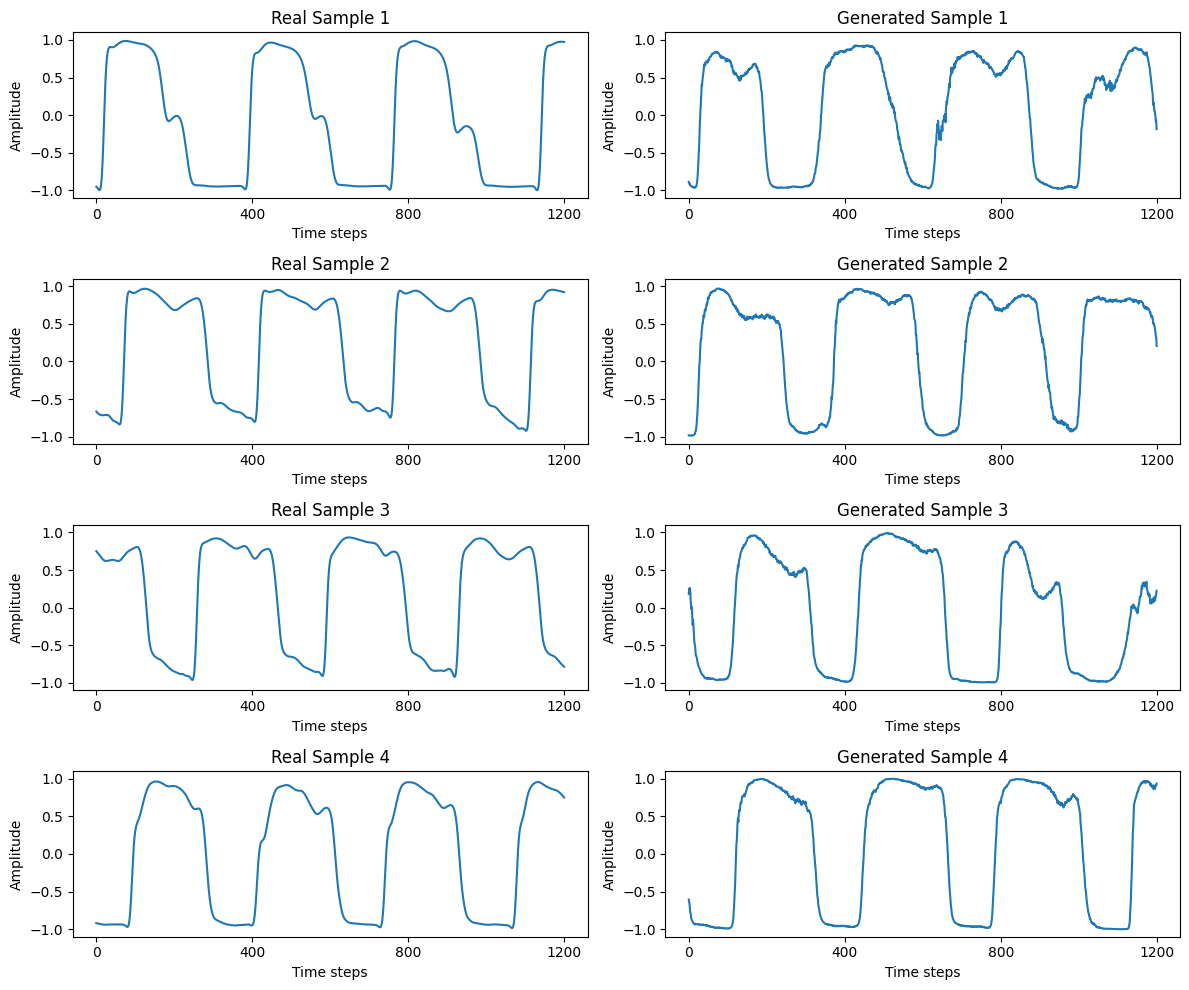

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt




# Parameters
NOISE_DIM = 64
num_samples = 4  # Match the number of samples in your image

# Define generator (same as in your training code)
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# Load real data
data_path = "/content/drive/MyDrive/park_right/park_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1  # Normalize to [-1, 1]
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# Load generator
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/park_right/saved_models_park_right/generator_epoch_100.weights.h5')

# Generate samples
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# Plotting
plt.figure(figsize=(12, 10))

for i in range(num_samples):
    # Real Sample
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.plot(real_samples[i, :])
    plt.title(f'Real Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

    # Generated Sample
    plt.subplot(num_samples, 2, 2*i + 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f'Generated Sample {i+1}')
    plt.xlabel('Time steps')
    plt.ylabel('Amplitude')
    plt.ylim(-1.1, 1.1)
    plt.xticks([0, 400, 800, 1200])

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


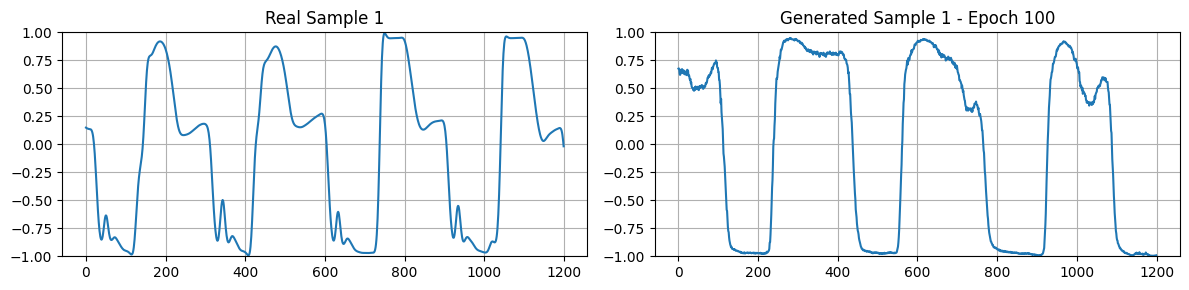

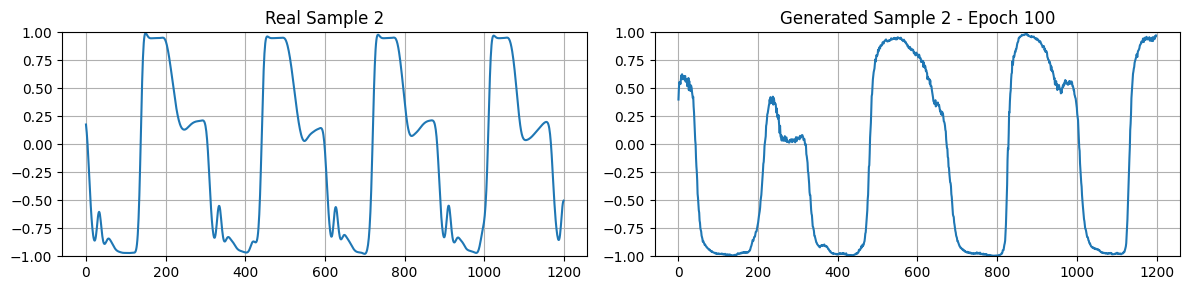

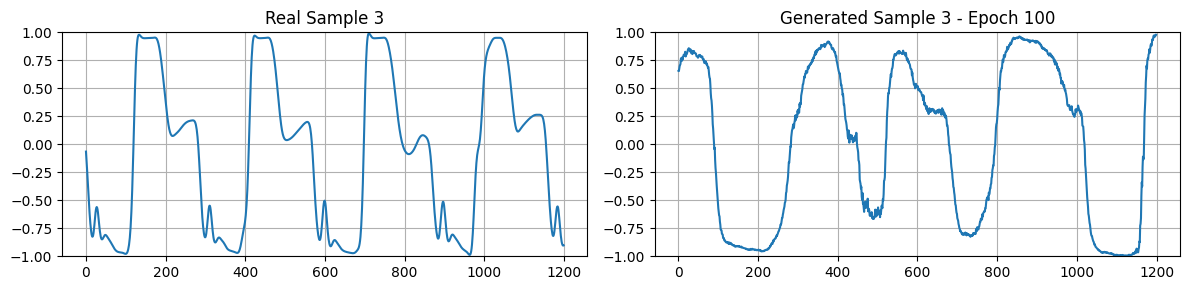

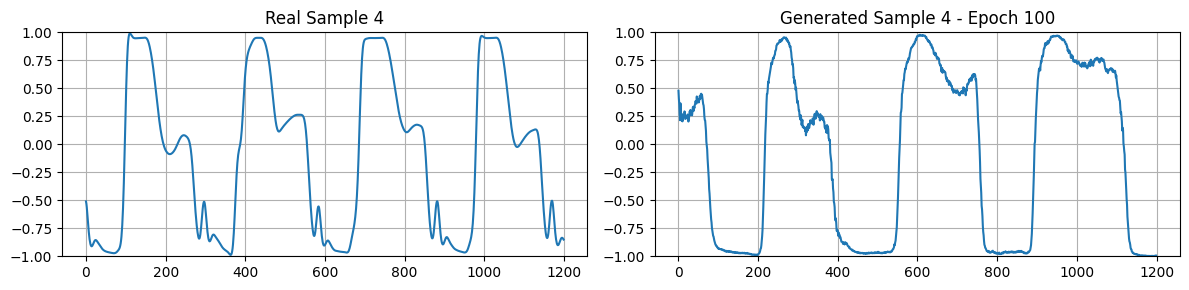

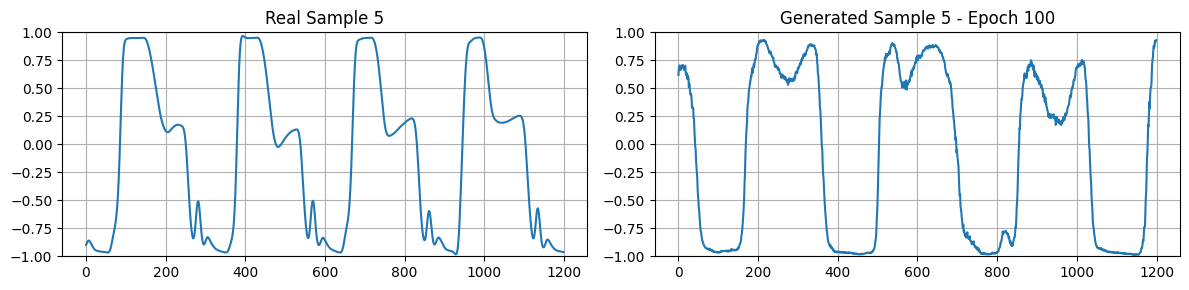

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# === Parameters ===
NOISE_DIM = 64
data_path = "/content/drive/MyDrive/park_right/park_all_right.npz"

# === Load data for comparison ===
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
data = data.astype(np.float32)

# === Redefine the generator architecture ===
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),

        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),

        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# === Load generator weights from epoch 100 ===
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/park_right/saved_models_park_right/generator_epoch_100.weights.h5')

# === Generate fixed noise and generate samples ===
fixed_noise = tf.random.normal([5, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False)

# === Plot real vs generated ===
for i in range(5):
    plt.figure(figsize=(12, 3))

    # Real sample
    plt.subplot(1, 2, 1)
    plt.plot(data[i, :, 0])
    plt.title(f"Real Sample {i+1}")
    plt.ylim(-1, 1)
    plt.grid(True)

    # Generated sample
    plt.subplot(1, 2, 2)
    plt.plot(generated_samples[i, :, 0])
    plt.title(f"Generated Sample {i+1} - Epoch 100")
    plt.ylim(-1, 1)
    plt.grid(True)

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


📏 MMD Score: 0.02000835732096968
🔄 Average DTW Distance: 10.951927763239507
🔁 Average Cross-Correlation: 0.03459042279391835


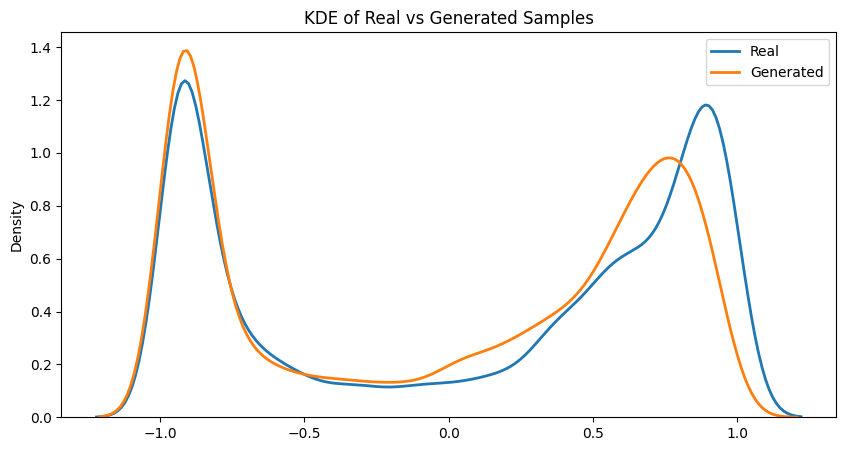

In [ ]:
!pip install dtaidistance

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel
from dtaidistance import dtw
import seaborn as sns

# --- Paramètres ---
NOISE_DIM = 64
num_samples = 100  # Nombre d'échantillons à comparer

# --- Chargement des données réelles ---
data_path = "/content/drive/MyDrive/park_right/park_all_right.npz"
data = np.load(data_path)['data']
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 2 - 1
real_samples = data[np.random.choice(data.shape[0], num_samples, replace=False)]

# --- Générateur ---
def build_generator():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(600, input_dim=NOISE_DIM),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Reshape((75, 8)),
        tf.keras.layers.Conv1DTranspose(128, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv1DTranspose(64, 15, strides=4, padding='same'),
        tf.keras.layers.ReLU(),
        tf.keras.layers.Conv1D(1, 15, padding='same', activation='tanh')
    ])
    return model

# --- Chargement du générateur préentraîné ---
generator = build_generator()
generator.load_weights('/content/drive/MyDrive/park_right/saved_models_park_right/generator_epoch_190.weights.h5')

# --- Génération des échantillons ---
fixed_noise = tf.random.normal([num_samples, NOISE_DIM])
generated_samples = generator(fixed_noise, training=False).numpy()

# --- MMD ---
def compute_mmd(x, y, gamma=1.0):
    xx = rbf_kernel(x, x, gamma=gamma)
    yy = rbf_kernel(y, y, gamma=gamma)
    xy = rbf_kernel(x, y, gamma=gamma)
    return np.mean(xx) + np.mean(yy) - 2 * np.mean(xy)

real_flat = real_samples.reshape(real_samples.shape[0], -1)
fake_flat = generated_samples.reshape(generated_samples.shape[0], -1)

mmd_score = compute_mmd(real_flat, fake_flat, gamma=0.1)
print("📏 MMD Score:", mmd_score)

# --- DTW ---
def compute_average_dtw(real_samples, generated_samples):
    dtw_distances = []
    for r, g in zip(real_samples, generated_samples):
        dist = dtw.distance(r.flatten(), g.flatten())
        dtw_distances.append(dist)
    return np.mean(dtw_distances)

dtw_score = compute_average_dtw(real_samples, generated_samples)
print("🔄 Average DTW Distance:", dtw_score)

# --- Cross-Correlation ---
def cross_correlation(a, b):
    a = (a - np.mean(a)) / (np.std(a) + 1e-8)
    b = (b - np.mean(b)) / (np.std(b) + 1e-8)
    return np.correlate(a, b, mode='valid')[0] / len(a)

ccs = [cross_correlation(r.flatten(), g.flatten()) for r, g in zip(real_samples, generated_samples)]
print("🔁 Average Cross-Correlation:", np.mean(ccs))

# --- Visualisation KDE ---
plt.figure(figsize=(10, 5))
sns.kdeplot(real_samples.reshape(-1), label="Real", linewidth=2)
sns.kdeplot(generated_samples.reshape(-1), label="Generated", linewidth=2)
plt.legend()
plt.title("KDE of Real vs Generated Samples")
plt.show()